In [19]:
using Interpolations

In [2]:
using FastGaussQuadrature

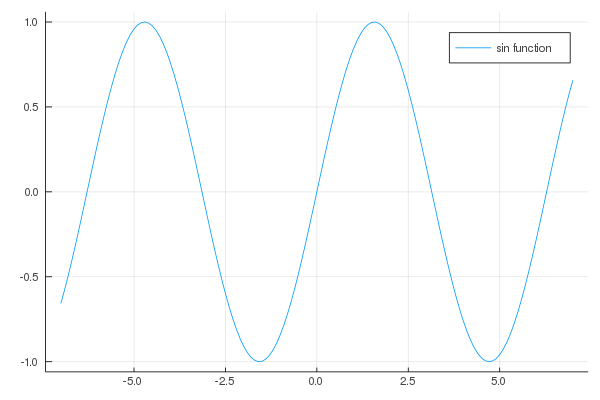

In [5]:
using Plots
gr(fmt=:png);
x = -7:7 # x points, coase grid
y = sin.(x) # corresponding y points
xf = -7:0.1:7 # fine grid
plot(xf, sin.(xf), label = "sin function")
#scatter!(x, y, label = "sampled data", markersize = 4)

In [7]:
#Let's set up the Acemoglu and Aghion model of directed technical change (2012)
#Parameters: 
struct Calibration
    α::Float64
    ρ::Float64
    ϵ::Float64
    ξ::Float64
    δ::Float64
    γ::Float64
    η_c::Float64
    η_d::Float64
end

#Calibration with Stern discount and "pessimistic" substitution possibilities. 
#I've not found which should be the values for ξ and δ
p=Calibration(1/3,0.001,3,0.06,0.05,1,0.02,0.02)

ϕ=(1-p.ϵ)*(1-p.α)

-1.3333333333333335

In [8]:
#let us define the model and solve it.
#However there are still some challenges so as to solve it (define machine and technological indexes)
#Variables: define initial values when constraints bind
#Labor
L_c0=0.5 #arbitrary
L_d0= 1.0-L_c0

#arbitrary initial prices for technologies
p_c0=1.0
p_d0=1.0

#Technology
#We need to define the continuum of machines xij (for j=c,d ; i belongs to (0,1)). 
#But it is a result of monopolistic competition. First define it as a constant then update its value as a result of optimization ?
#In our situation, the clean sector must initially be less advanced than the dirty one
A_d0=1.0
#the proper distance between the two technologies can be expressed with the parameters
a=(((1.0+p.γ*p.η_c)^(-((ϕ+1.0)/ϕ)))*(p.η_c/p.η_d)^(1.0/ϕ), ((1.0+p.γ*p.η_d)^(ϕ+1/ϕ))*(p.η_c/p.η_d)^(1.0/ϕ))
b=minimum(a)
A_c0=b*(A_d0)

#scientists
#binding constraint
#fully competitive so all scientists work in most advanced sector (ie. the dirty one) at the beginning
s_d0 = 1.0
s_c0 = 1.0-s_d0

#the scientists' profit
#initial profit

Π_c0=p.η_c*(1.0+p.γ)*(1.0-p.α)*p.α*p_c0^(1.0/(1.0-p.α))*L_c0*A_c0
Π_d0=p.η_d*(1.0+p.γ)*(1.0-p.α)*p.α*p_d0^(1.0/(1.0-p.α))*L_d0*A_d0

#Law of motion of technology
#the number of scientists in this period, the technology in the previous, helps yield technology nows
function dirty_technology(A_d::Float64,s_d::Float64,p::Calibration)::Float64
    A_=(1.0+p.γ*p.η_d*s_d)*A_d
    return A_
end

function clean_technology(A_c::Float64,s_c::Float64,p::Calibration)::Float64
    A_=(1.0+p.γ*p.η_c*s_c)*A_c
    return A_
end

#define profit at period t
function profit_dirty(L_d::Float64,A_d::Float64,p_d::Float64,p::Calibration)
    Pi_d=p.η_d*(1.0+p.γ)*(1.0-p.α)*p.α*p_d^(1.0/(1.0-p.α))*L_d*A_d
    return Pi_d
end

function profit_clean(L_c::Float64,A_c::Float64,p_c::Float64,p::Calibration)
    Pi_c=p.η_c*(1.0+p.γ)*(1.0-p.α)*p.α*p_c^(1.0/(1.0-p.α))*L_c*A_c
    return Pi_c
end

#We can thus define production in each sector as a function of technology and labor
#needs indexes and integrals which I don't know how to implement, so I set arbitrary values
Y_d0=0.5
Y_c0=0.5

Y0=(Y_c0^((p.ϵ-1.0)/p.ϵ)+Y_d0^((p.ϵ-1.0)/p.ϵ))^(p.ϵ/(p.ϵ-1.0))

#The environment law of motion

function pollution(Y::Float64,S::Float64,S0::Float64,p::Calibration)::Float64
    if S<S0
        S_=-p.ξ*Y0+(1.0+p.δ)*S
    else
        S_=-p.ξ*Y0 + S
    end
    return S_
end
#Let us assume the initial state of the environment is comparable to initial product
S0=Y0

#c=pollution(Y0,S0,S0,p)



1.4142135623730951

In [9]:
#For the moment being, I just use the equilibrium formulas yielded in the paper to try and compute the paths
#Profit ratio (A in the previous period, and current period scientists)
function profit_ratio(A_c::Float64,s_c::Float64,A_d::Float64,s_d::Float64,p::Calibration)::Float64
    ϕ=(1-p.ϵ)*(1-p.α)
    ratio=(p.η_c/p.η_d)*(((1+p.γ*p.η_c*s_c)/(1+p.γ*p.η_d*s_d))^(-(ϕ+1)))*(A_c/A_d)^(-ϕ)
    return ratio
end

#Depending on the size of the ratio, scientists are directed to one sector or another
d=profit_ratio(A_c0,s_c0,A_d0,s_d0,p)

#Equilibrium value for the products

function clean_product(A_c::Float64,A_d::Float64,p::Calibration)::Float64
    ϕ=(1-p.ϵ)*(1-p.α)
    product_c=((A_c^(ϕ)+A_d^(ϕ))^(-(p.α+ϕ)/ϕ))*A_c*A_d^(p.α+ϕ)
    return product_c
end

function dirty_product(A_c::Float64,A_d::Float64,p::Calibration)::Float64
    ϕ=(1-p.ϵ)*(1-p.α)
    product_d=((A_c^(ϕ)+A_d^(ϕ))^(-(p.α+ϕ)/ϕ))*A_d*A_c^(p.α+ϕ)
    return product_d
end

function product(A_c::Float64,A_d::Float64,p::Calibration)::Float64
    ϕ=(1-p.ϵ)*(1-p.α)
    product=(A_c^(ϕ)+A_d^(ϕ))^(-(1/ϕ))*A_d*A_c
    return product
end


product (generic function with 1 method)

In [10]:
#After having defined all law of motions, we can define the transition equation
function transition(Y,S,Y_c,A_c,s_c,Y_d,A_d,s_d,S0,p)
    pi_ratio=profit_ratio(A_c,s_c,A_d,s_d,p)
    if pi_ratio > 1
        s_c=1.0
        s_d=0.0
    else
        s_c=0.0
        s_d=1.0
    end
    A_d=dirty_technology(A_d,s_d,p)
    A_c=clean_technology(A_c,s_c,p)
    Y_c=clean_product(A_c,A_d,p)
    Y_d=dirty_product(A_c,A_d,p)
    Y=product(A_c,A_d,p)
    S=pollution(Y,S,S0,p)
    return [Y,S,Y_c,A_c,s_c,Y_d,A_d,s_d]
end

vector=transition(Y0,S0,Y_c0,A_c0,s_c0,Y_d0,A_d0,s_d0,S0,p)

8-element Vector{Float64}:
 1.664883480665517
 1.3293607486307095
 0.553072553377136
 0.9595839503280009
 0.0
 0.6249085969572552
 1.02
 1.0

In [11]:
#Let's try a simulation for the laissez faire equilibrium !
#Initial conditions are defined up above

#Would simplify the algorithm but can't figure out right now how to make the function work with vectors
#variables=(Y0,S0,Y_c0,A_c0,s_c0,Y_d0,A_d0,s_d0)
#parameters=(S0,p)
#transition(variables,parameters)
S_C=[s_c0]
S_D=[s_d0]
Y_C=[Y_c0]
Y_D=[Y_d0]
Y=[Y0]
S=[S0]
A_C=[A_c0]
A_D=[A_d0]
T=[0]

t=100
for i=1:t
    Y0,S0,Y_c0,A_c0,s_c0,Y_d0,A_d0,s_d0=transition(Y0,S0,Y_c0,A_c0,s_c0,Y_d0,A_d0,s_d0,S0,p)
    push!(S_C,s_c0)
    push!(S_D,s_d0)
    push!(Y_C,Y_c0)
    push!(Y_D,Y_d0)
    push!(Y,Y0)
    push!(S,S0)
    push!(A_C,A_c0)
    push!(A_D,A_d0)
    push!(T,i)
end

In [18]:
using Plots
gr(fmt=:png);
x = 1:101 # x points, coase grid
y = S[x] # corresponding y points
xf = 1:0.1:101 # fine grid
plot(x, S[x], label = "sin function")

#using Plots
#gr(fmt=:png)
#pl = plot( [el for el in S], label="environment destruction")
#pl1 = plot(x=1:T, [el for el in B], label="convergence of capital")

#using Plots
#gr(fmt=:png);
#x = -7:7 # x points, coase grid
#y = sin.(x) # corresponding y points
#xf = -7:0.1:7 # fine grid
#plot(xf, sin.(xf), label = "sin function")

#GRISU NOT DEFINED EARLIER
